<a href="https://colab.research.google.com/github/nengelmann/Fuyu-8B---Exploration/blob/main/Fuyu_8B_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fuyu-8B Exploration 🤓 🔍**

**Explore** the capabilities of **fuyu-8b** for memes and other use cases.

## Installation 💿

In [1]:
!pip install -q transformers bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.2 MB/s eta 0:00:00


## Imports ↙️

In [2]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig
import pdb

## Helper functions ⚒️

In [3]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)



## Model definition ⚙️

In [4]:
# check runtime type
if torch.cuda.is_available():
  model_id="ybelkada/fuyu-8b-sharded"
  print(f"\nUsing the sharded model '{model_id}' with to GPU usage.\n")
  print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
  model_id="adept/fuyu-8b"
  print(f"\nUsing the original model '{model_id}' without GPU usage.\n")
  print("This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.")
  print("Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!\n")
  print("⚠️ For the sake of time, switch the runtime type to 'T4 GPU' or any other GPU type, otherwise it will take literally hours!\n")



Using the sharded model 'ybelkada/fuyu-8b-sharded' with to GPU usage.

This model is faster due to 4bit quantization and GPU computation. 🚀



In [5]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = self.processor(text=text, images=[image], return_tensors="pt").to(self.device)
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = self.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

## Model instantiation ⏳

This might run a few minutes while downloading the weights. \
Time for a coffee! ☕

**If the execution fails** 💥, it is likely an out of memory error of CUDA (GPU) or your system RAM.
You should disconnect and delete the current runtime environment, then re-run all cells.

In [6]:
fuyu = Fuyu(model_id)

You are running the model on GPU.


Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

## Meme Examples 😂


In [7]:
#@title Define prompt for all memes.
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n" #@param

### Meme: Face palm - "I can't even"

[Example](https://memecomplete.com/edit/images/facepalm/_/I_can't_even.png%3Ftoken=yt2ys5jsfx72zoi11jnh) from [Memegen.link](https://memegen.link/examples/)

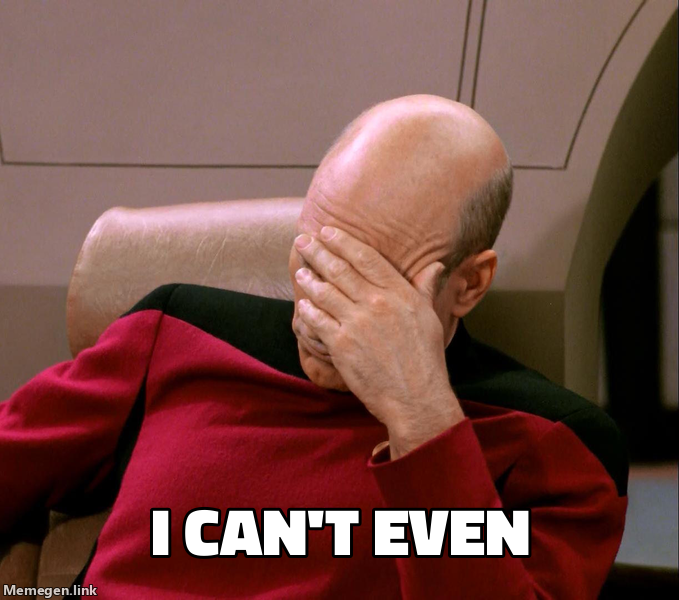


Generation time: 10s

Given image
https://api.memegen.link/images/facepalm/_/I_can't_even.png and the following prompt:

Extract the
text contained within the image. The extracted text in relation to the image
content represent a joke or funny situation. Explain why it is funny.

The models output:

The image features a bald man sitting with his hands
covering his face, seemingly covering his eyes. This scene is humorous because it
captures a humorous moment where the man is pretending to cover his eyes with his hands. The
caption accompanying the image adds to the humorous atmosphere by stating that "I CAN'T
EVEN". This text emphasizes the absurdity of the situation, making the scene even more
amusing.



In [8]:
img_url = "https://api.memegen.link/images/facepalm/_/I_can't_even.png"
run_example(prompt, img_url)

### Meme: What year is it?

[Example](https://memecomplete.com/edit/images/whatyear/_/what_year_is_it~q.png%3Ftoken=miijb4kvs9jeb0uddvzt) from [Memegen.link](https://memegen.link/examples/)

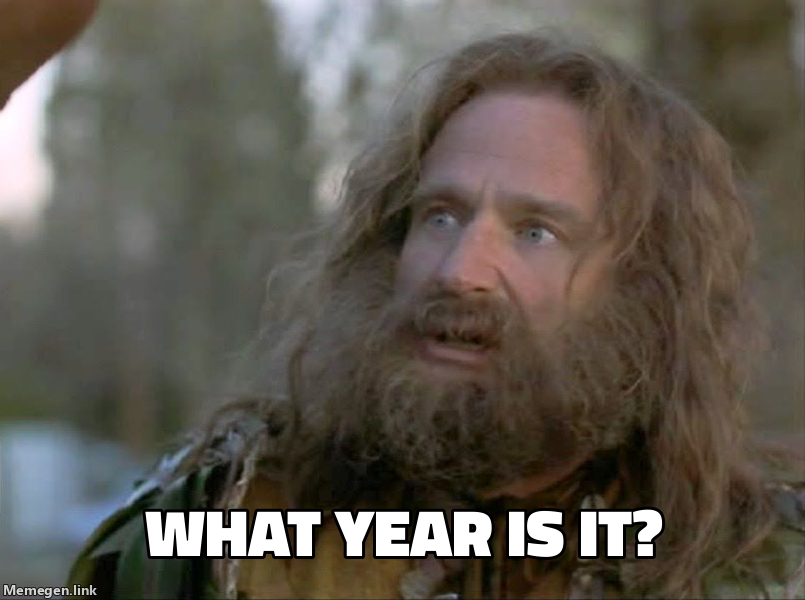


Generation time: 4s

Given image
https://api.memegen.link/images/whatyear/_/what_year_is_it~q.png and the following prompt:

Extract
the text contained within the image. The extracted text in relation to the image
content represent a joke or funny situation. Explain why it is funny.

The models output:

The image features a man in a bearded outfit,
wearing a brown coat and carrying a backpack. The caption at the bottom of the image reads,
"What year is it?", implying that the man is referring to the year in which the photo was
taken. This humorous statement emphasizes the humorous nature of the scene and adds an
element of light-heartedness to the overall content.



In [9]:
img_url = "https://api.memegen.link/images/whatyear/_/what_year_is_it~q.png"
run_example(prompt, img_url)

### Meme: Someone on the internet disagrees
[Example](https://memecomplete.com/edit/images/fwp/someone_on_the_internet/disagrees_with_me.png%3Ftoken=m9yv0xjn09jeb0uddvzt) from [Memegen.link](https://memegen.link/examples/)

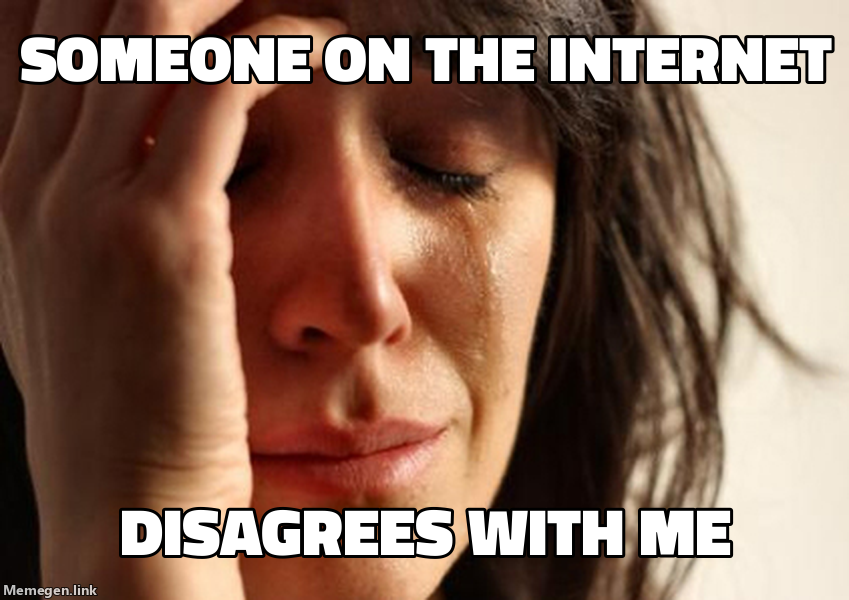


Generation time: 7s

Given image
https://api.memegen.link/images/fwp/someone_on_the_internet/disagrees_with_me.png and the following
prompt:

Extract the text contained within the image. The extracted text in
relation to the image content represent a joke or funny situation. Explain why it is
funny.

The models output:

The image features a woman with a sad expression,
possibly frowning or looking down. She is holding the index finger of her right hand up to
her forehead, indicating her distress or frustration. This scene is humorous because it
portrays a woman expressing her emotions in a light-hearted and comical manner. The
caption accompanying the image adds to the humorous nature of the scene by highlighting her
facial expression and "dis agrees with me." This amusing exchange can spark laughter
and entertainment among viewers.



In [10]:
img_url = "https://api.memegen.link/images/fwp/someone_on_the_internet/disagrees_with_me.png"
run_example(prompt, img_url)

### Meme: Have you ever eaten a clock

[Example](https://memecomplete.com/edit/images/captain-america/Have_you_ever_eaten_a_clock~q/No,_why~q/It's_time_consuming..png%3Ftoken=cdilu5l4f4e96vp88quo) from [Memegen.link](https://memegen.link/examples/)

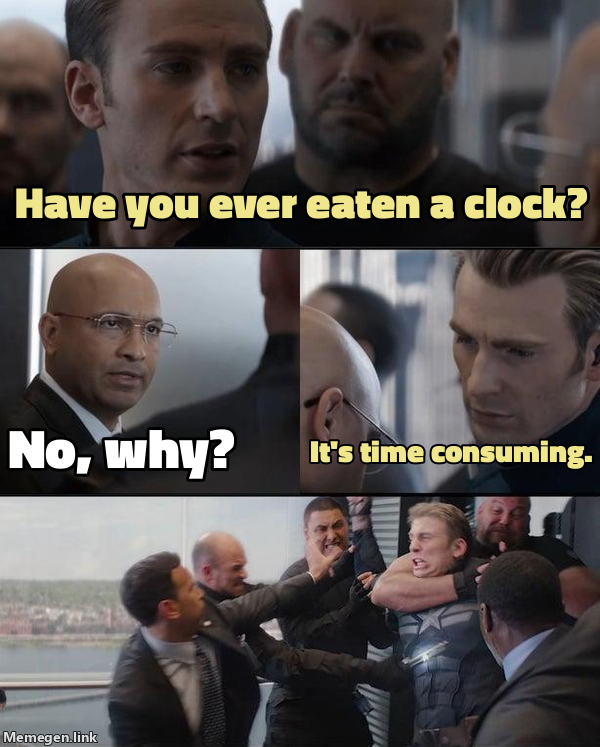


Generation time: 8s

Given image
https://api.memegen.link/images/captain-america/Have_you_ever_eaten_a_clock~q/No,_why~q/It's_time_consuming..png and
the following prompt:

Extract the text contained within the
image. The extracted text in relation to the image content represent a joke or
funny situation. Explain why it is funny.

The models output:

The image features multiple scenes of people engaged
in conversations with each other. In one of the scenes, a man is talking into a
microphone, while another man claps his hands. These scenes showcase various expressions of
emotions, such as laughter, happiness, and joy. The humorous context of these scenes is a
result of people engaging in light-hearted conversations and participating in
light-hearted actions. The scenes are humorous because they portray a casual and enjoyable
atmosphere, where people are sharing light-hearted moments with each other.



In [11]:
img_url = "https://api.memegen.link/images/captain-america/Have_you_ever_eaten_a_clock~q/No,_why~q/It's_time_consuming..png"
run_example(prompt, img_url)

### Meme: Noah - "What the hell is this?"

[Example](https://memecomplete.com/edit/images/noah/Street/Road/Stroad/What_the_hell_is_this~q.png%3Ftoken=oa7pk4hfoakfc1veew0u) from [Memegen.link](https://memegen.link/examples/)

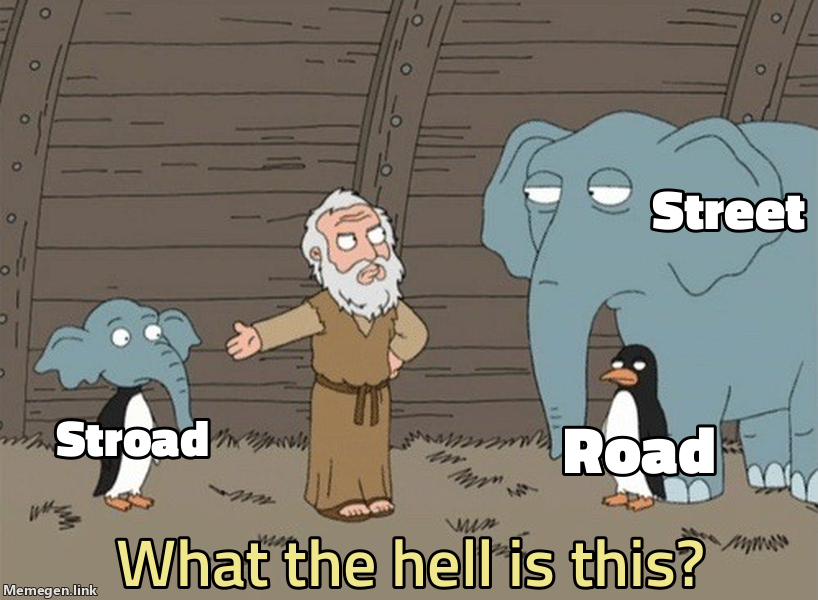


Generation time: 7s

Given image
https://api.memegen.link/images/noah/Street/Road/Stroad/What_the_hell_is_this~q.png and the following
prompt:

Extract the text contained within the image. The extracted text in
relation to the image content represent a joke or funny situation. Explain why it
is funny.

The models output:

The funny situation depicted in the image involves a
shepherd talking to a sheep and a bird. The shepherd is wearing a brown outfit and
talking to the sheep and bird, which are depicted as "street" characters. This scene is
humorous because it parodies a familiar scene, where a person dressed like Jesus is talking
to a sheep and a bird. The humor arises from the contrast between the "street"
characters and the "real" shepherd. The viewer is drawn to the humorous contrast between the
"street"



In [12]:
img_url = "https://api.memegen.link/images/noah/Street/Road/Stroad/What_the_hell_is_this~q.png"
run_example(prompt, img_url)

### Meme: Engineer - "Is this Photoshop?"

[Example](https://memecomplete.com/edit/images/pigeon/Engineer/PowerPoint/Is_this_Photoshop~q.png%3Ftoken=slz67cqqdcmhe3xggy2w) from [Memegen.link](https://memegen.link/examples/)

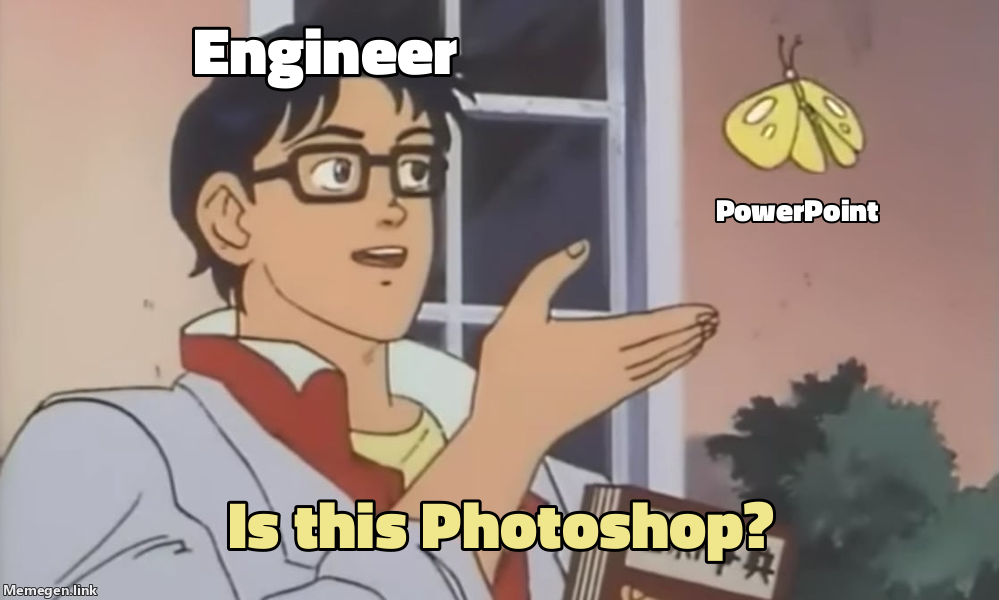


Generation time: 7s

Given image
https://api.memegen.link/images/pigeon/Engineer/PowerPoint/Is_this_Photoshop~q.png and the following
prompt:

Extract the text contained within the image. The extracted text in
relation to the image content represent a joke or funny situation. Explain why it is
funny.

The models output:

The image features a cartoon-style drawing of a man
with glasses and a tie, standing in front of a window. The caption at the bottom reads,
"Is this Photoshop?" The cartoon-style drawing and humorous wording make the image
amusing and entertaining. The joke is related to the exaggerated facial features, making the
image more light-hearted and comical. The caption at the bottom emphasizes the humorous
nature of the scene and adds context to the humorous nature of the joke.



In [13]:
img_url = "https://api.memegen.link/images/pigeon/Engineer/PowerPoint/Is_this_Photoshop~q.png"
run_example(prompt, img_url)

### Meme: Just Graduated? - "You must know everything"

[Example](https://memecomplete.com/edit/images/wonka/oh,_you_just_graduated~q/you_must_know_everything.png%3Ftoken=e87k5c7t65fa7wq99rvp) from [Memegen.link](https://memegen.link/examples/)

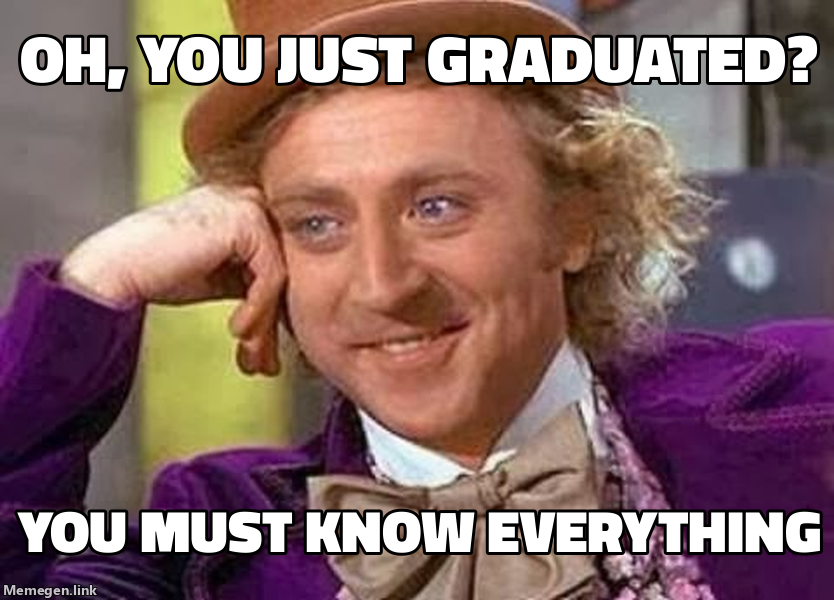


Generation time: 8s

Given image
https://api.memegen.link/images/wonka/oh,_you_just_graduated~q/you_must_know_everything.png and the following
prompt:

Extract the text contained within the image. The extracted
text in relation to the image content represent a joke or funny situation. Explain
why it is funny.

The models output:

The image features a smiling Willy Wonka with a
purple jacket and bow tie, who is wearing a purple suit and posing for a picture. The
caption at the bottom of the image reads, "You Must Know Everything." This text suggests that
Willy Wonka is sharing his wisdom and wisdom-filled advice, making it an entertaining
and humorous scene. The joke is related to the Willy Wonka character from the movie
Charlie and the Chocolate Factory, who is famous for his eccentric and often surreal
personality. The joke is amusing and amusing for the viewers who



In [14]:
img_url = "https://api.memegen.link/images/wonka/oh,_you_just_graduated~q/you_must_know_everything.png"
run_example(prompt, img_url)

### Meme: Monday Slap - "Me trying to enjoy the weekend"

[Example](https://memecomplete.com/edit/images/slap/Me_Trying_to_Enjoy_the_Weekend/Monday.png%3Ftoken=qiyelixapblgd2wffx1v) from [Memegen.link](https://memegen.link/examples/)

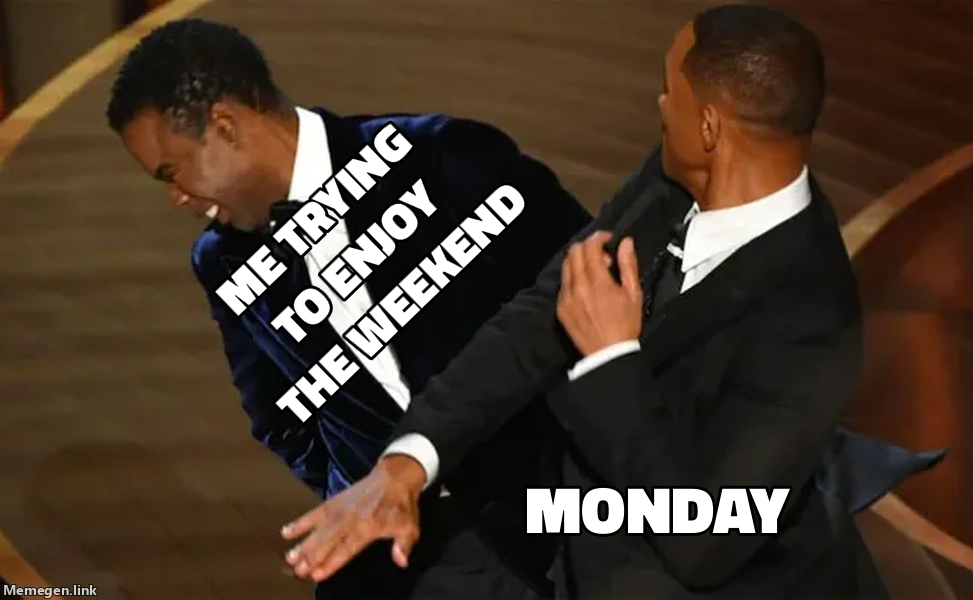


Generation time: 7s

Given image
https://api.memegen.link/images/slap/Me_Trying_to_Enjoy_the_Weekend/Monday.png and the following
prompt:

Extract the text contained within the image. The extracted text in relation
to the image content represent a joke or funny situation. Explain why it is
funny.

The models output:

The image features two men standing next to each
other, engaged in conversation. One of the men is wearing a suit and tie, while the other
is wearing a black shirt. The scene is humorous because it portrays the interaction
between the two men, as they engage in a playful exchange. The humor arises from the contrast
between the formal attire of the suit-wearing man and the more casual attire of the
shirt-wearing man. This light-hearted interaction showcases their friendly relationship and
creates a light-hearted atmosphere that invokes laughter and joy among viewers.



In [15]:
img_url = "https://api.memegen.link/images/slap/Me_Trying_to_Enjoy_the_Weekend/Monday.png"
run_example(prompt, img_url)

## Try it yourself 🫵

Choose an online image link, define your promt and see what happens!

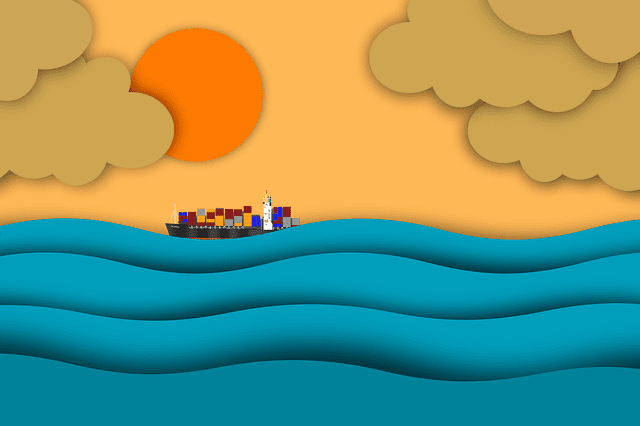


Generation time: 4s
The image features a large boat floating on the water, surrounded by clouds and waves.
There is also a smaller boat nearby. These objects together create a sense of an ocean
scene, capturing the essence of the ocean and its environment. The boats are floating on
calm waters, emphasizing a sense of tranquility and relaxation.


In [16]:
prompt= "Explain what objects are in this image."        #@param {type:"string"}
image_url = "https://learnopencv.com/wp-content/uploads/2021/04/image-15.png"        #@param {type:"string"}
out_tokens = 50           #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

## Use the model directly 🤓

In [17]:
# prompt and image
prompt = "What do you think about this stunning view?"
img_url = "https://scx2.b-cdn.net/gfx/news/hires/2022/an-image-of-the-carina.jpg"

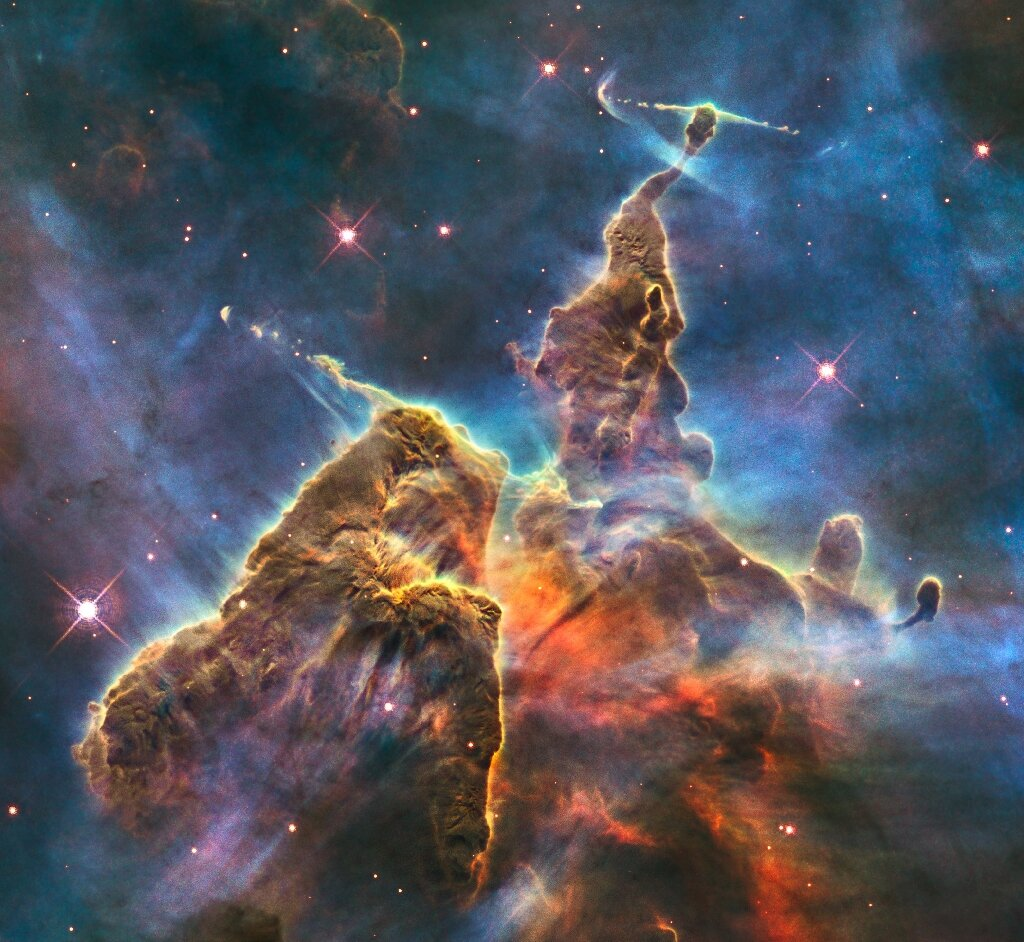

In [18]:
# get image and show it
image = url_to_image(img_url)
show(image)

In [19]:
# run the model
output = fuyu.prompt(prompt, image, out_tokens=50)
print(output)


Generation time: 5s
The stunning view in the image features two large stars and a bright sky with a multitude of stars. The stars in the background are surrounded by colorful clouds, creating a vibrant and celestial atmosphere. The scene is reminiscent of a painting or outer space, capturing the essence of the cosmo


If you like this notebook, please consider to give it a ⭐ on github. \
https://github.com/nengelmann/Fuyu-8B---Exploration